# Modeling

We are now in the modeling phase. We still have some features that have interactions (Age and BMI, smoking/drinking, etc.) but most features have been engineered to eliminate the worst interactions and correlation

The model I've chosen is XGBoost, which is tolerant to some feature interaction, and will work well with the engineered features I've created, without requiring any new features

In [1]:
!pip install xgboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dython import nominal
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    cross_val_score,
    learning_curve,
    train_test_split,
    train_test_split,
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from xgboost import XGBClassifier


random_state = 0

In [3]:

# Load the prepared features
df = pd.read_feather('selected_features_df.feather')
fdf = pd.read_feather('selected_features_fdf.feather')

In [4]:
# Split features and target
X = fdf.drop('diabetes', axis=1)
y = fdf['diabetes']

# train test split
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.2, random_state=random_state)

smote = SMOTE(random_state=random_state)
X_train, y_train = smote.fit_resample(X_train_full, y_train_full)

print(f"Training set shape after SMOTE: {X_train.shape}")
print(f"Class distribution after SMOTE: {pd.Series(y_train).value_counts(normalize=True)}")

Training set shape after SMOTE: (301282, 15)
Class distribution after SMOTE: diabetes
True     0.5
False    0.5
Name: proportion, dtype: float64


In [5]:

# Train XGBoost model
xgb = XGBClassifier(eval_metric='aucpr', random_state=random_state)
xgb.fit(X_train, y_train)

# Make predictions
y_pred = xgb.predict(X_test_full)
y_pred_proba = xgb.predict_proba(X_test_full)[:, 1]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test_full, y_pred))
print("ROC AUC:", roc_auc_score(y_test_full, y_pred_proba))
print("F1 Score:", f1_score(y_test_full, y_pred))
print("\nClassification Report:")
print(classification_report(y_test_full, y_pred))

Accuracy: 0.7793840351979887
ROC AUC: 0.7774862977975538
F1 Score: 0.4442260442260442

Classification Report:
              precision    recall  f1-score   support

       False       0.88      0.85      0.86     37674
        True       0.41      0.48      0.44      8465

    accuracy                           0.78     46139
   macro avg       0.65      0.66      0.65     46139
weighted avg       0.79      0.78      0.79     46139



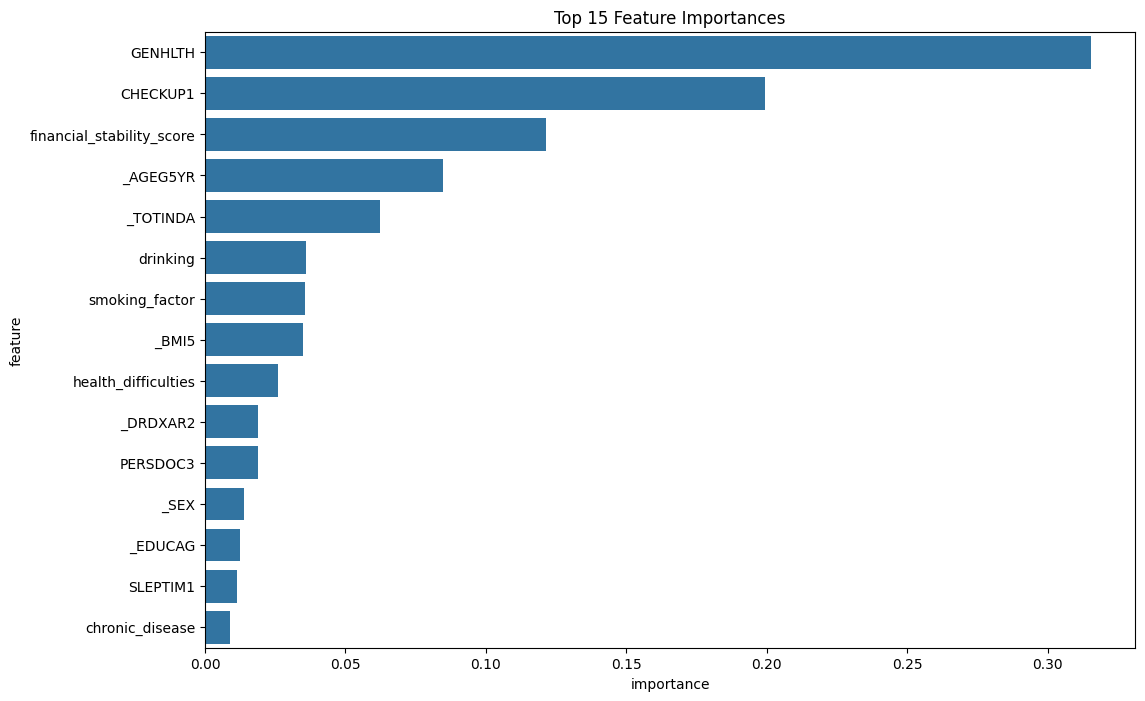

In [6]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importances')
plt.show()



Detailed Classification Report:
              precision    recall  f1-score   support

       False       0.88      0.85      0.86     37674
        True       0.41      0.48      0.44      8465

    accuracy                           0.78     46139
   macro avg       0.65      0.66      0.65     46139
weighted avg       0.79      0.78      0.79     46139



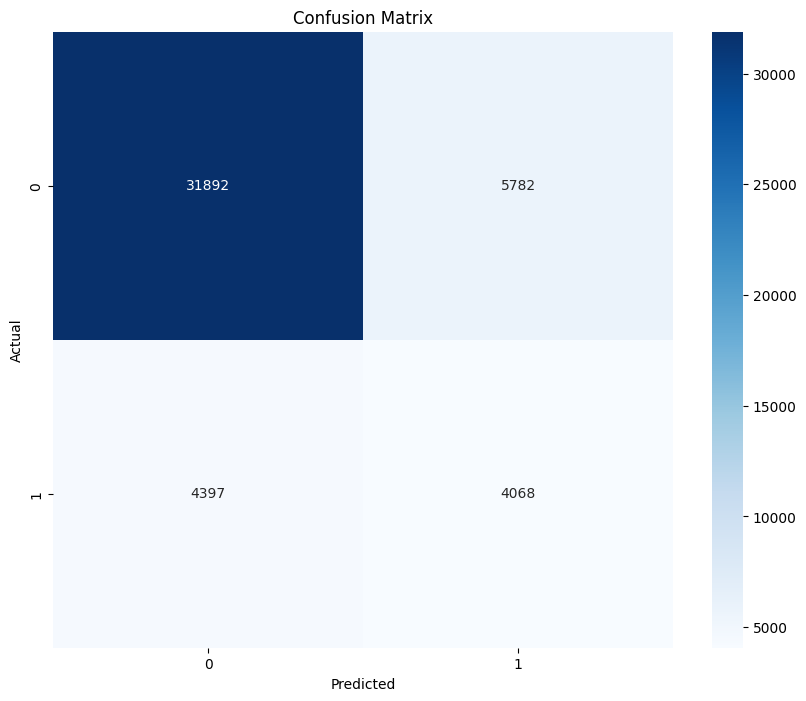


Confusion Matrix Interpretation:
True Negatives: 31892
False Positives: 5782
False Negatives: 4397
True Positives: 4068


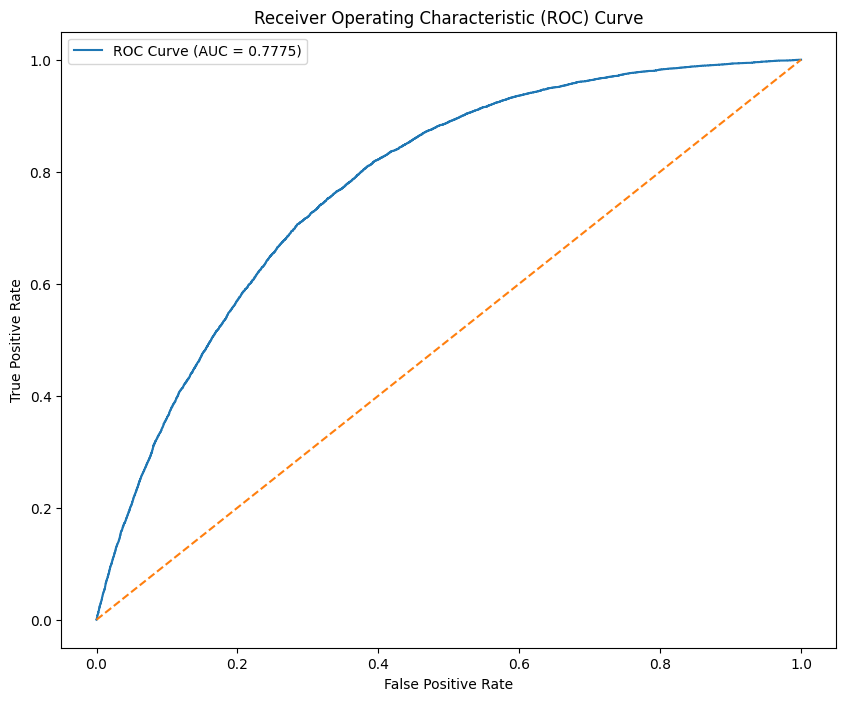

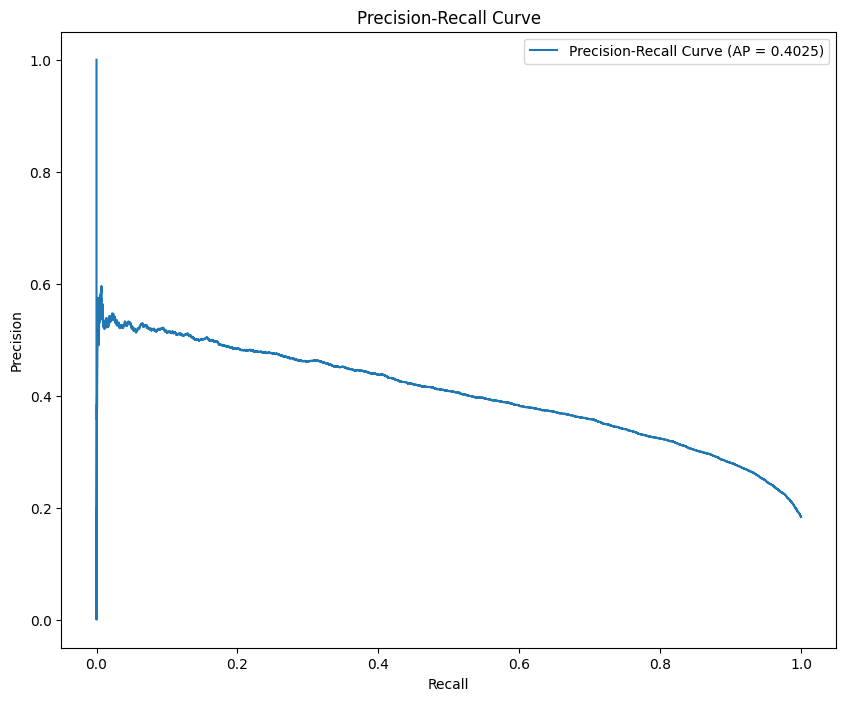

In [7]:
# Detailed Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_test_full, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test_full, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("\nConfusion Matrix Interpretation:")
print(f"True Negatives: {cm[0][0]}")
print(f"False Positives: {cm[0][1]}")
print(f"False Negatives: {cm[1][0]}")
print(f"True Positives: {cm[1][1]}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_full, y_pred_proba)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test_full, y_pred_proba):.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_full, y_pred_proba)
avg_precision = average_precision_score(y_test_full, y_pred_proba)
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


Cross-validation scores: [0.60268517 0.85181805 0.86885953 0.87202934 0.87131572]
Mean CV score: 0.8133 (+/- 0.2112)


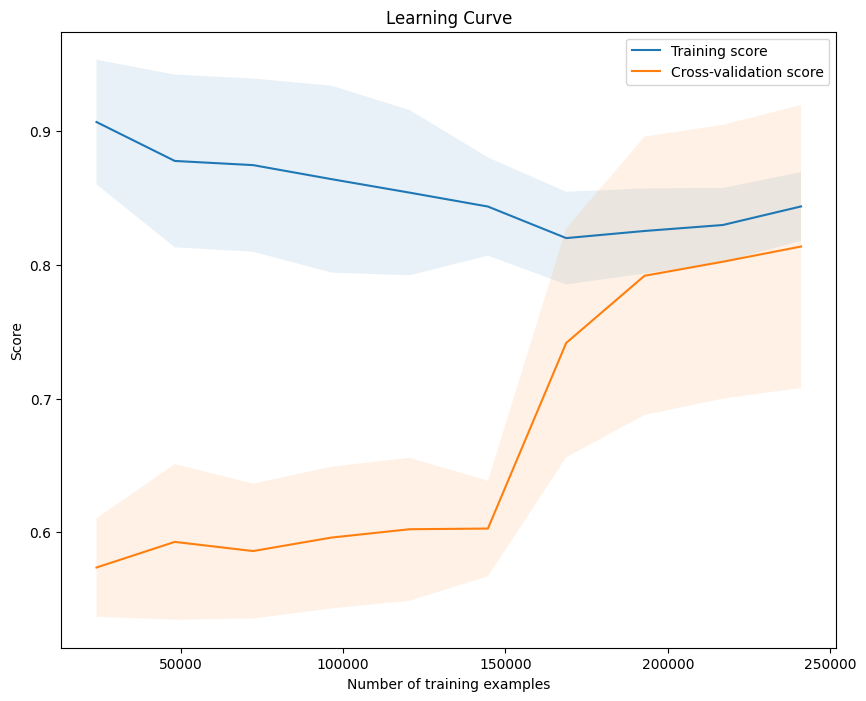

In [8]:
# Cross-validation
cv_scores = cross_val_score(xgb, X_train, y_train, cv=5)
print("\nCross-validation scores:", cv_scores)
print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(xgb, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 8))
plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Number of training examples')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()

# Hyperparamter tuning

As noted in the EDA, we have a very unbalanced class, so we'll validate scale_pos_weight, in addition to all the "standard" params to tune across.

In [9]:
original_xgb = xgb
original_y_pred = y_pred
original_y_pred_proba = y_pred_proba

In [24]:
xgb = XGBClassifier(random_state=random_state)

param_dist = {
    'eval_metric': ['aucpr', 'auc', 'logloss'],
    'n_estimators': [100, 200, 300],
    'max_depth': [1, 3, 5, 6, 7, 9],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.3, 0.5],
    'lambda': [1,2,3],
    'scale_pos_weight': [1, sum(y_test_full == 0) / sum(y_test_full == 1)],
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,
    scoring='roc_auc',                     # We'll optimize for ROC AUC
    cv=5,                                  # 5-fold cross-validation
    verbose=1,
    random_state=random_state,
    n_jobs=-1                              
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           num_parallel_tree=None,
                                           random_state=0, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'eval_metric': ['aucpr', 'auc',
                                                        'logloss'],
                                        'gamma': [0, 0.1, 0.3, 0.5],
                                        'lambda': [1, 2, 3],
                                        'max_depth': [1, 3, 5, 6, 7, 9],
                                        'min_child_weight': [1, 2, 3],
                                        'n_estimators': [100, 200, 300],
                                        'scale_pos_weight': [1,
                                                             4.4505611340815125],
                                        'subsample': [0.5, 0.7, 0.9, 1.0]},
                   random_state=0, scoring='roc_auc', verbose=1)

In [25]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_full)
y_pred_proba = best_model.predict_proba(X_test_full)[:, 1]


Detailed Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.70      0.79     37674
        True       0.33      0.66      0.44      8465

    accuracy                           0.70     46139
   macro avg       0.62      0.68      0.62     46139
weighted avg       0.80      0.70      0.73     46139



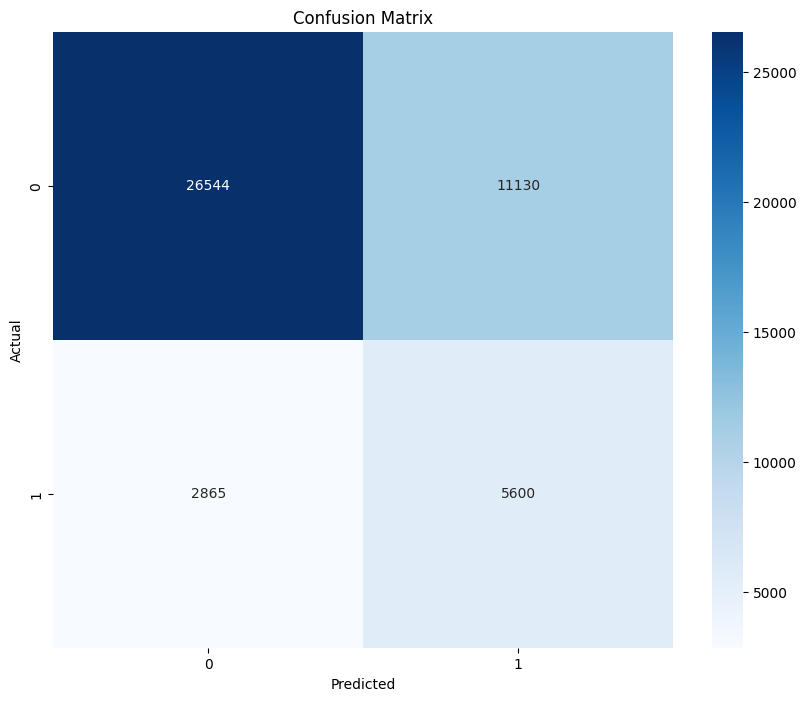


Confusion Matrix Interpretation:
True Negatives: 26544
False Positives: 11130
False Negatives: 2865
True Positives: 5600


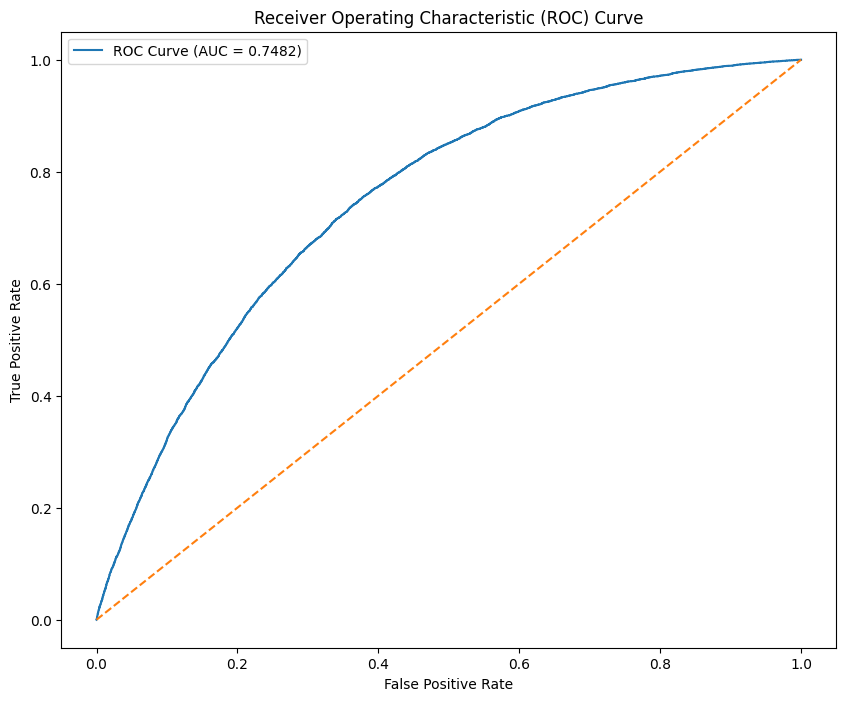

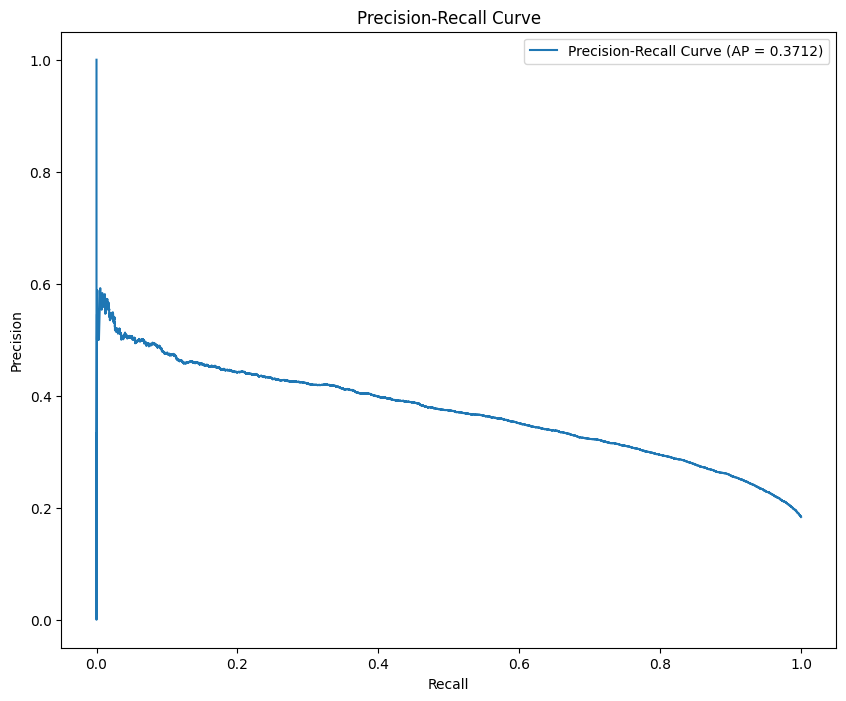

In [26]:
# Detailed Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_test_full, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test_full, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("\nConfusion Matrix Interpretation:")
print(f"True Negatives: {cm[0][0]}")
print(f"False Positives: {cm[0][1]}")
print(f"False Negatives: {cm[1][0]}")
print(f"True Positives: {cm[1][1]}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_full, y_pred_proba)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test_full, y_pred_proba):.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_full, y_pred_proba)
avg_precision = average_precision_score(y_test_full, y_pred_proba)
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

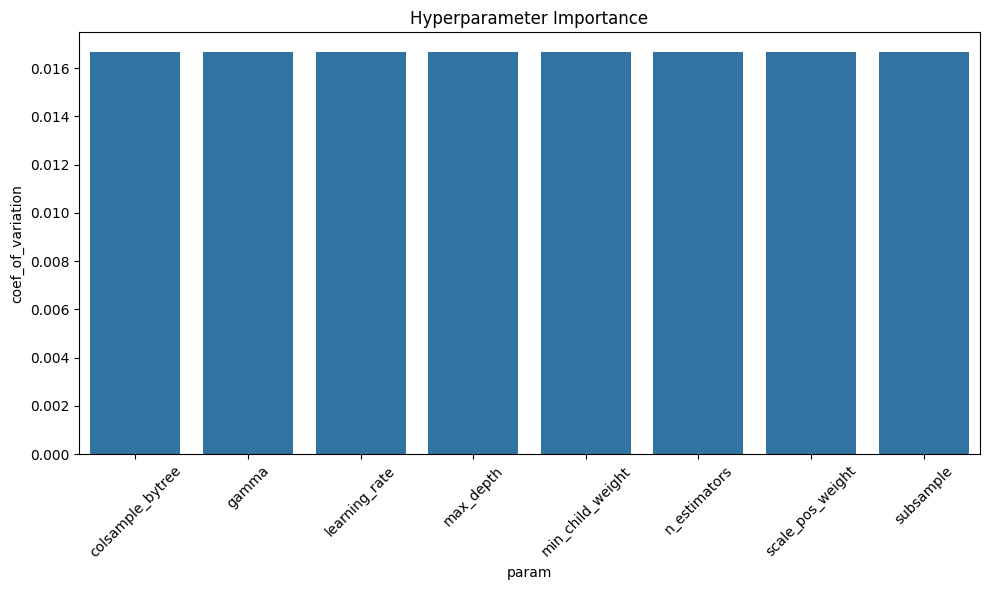

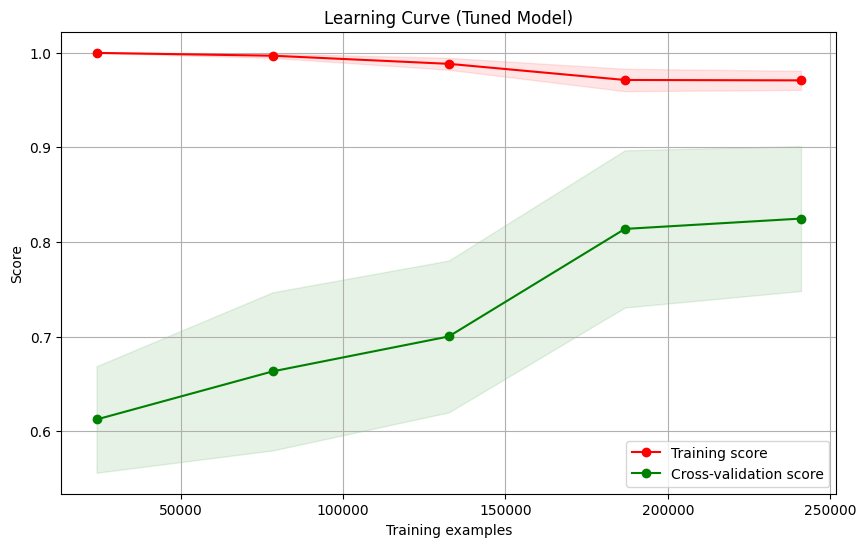

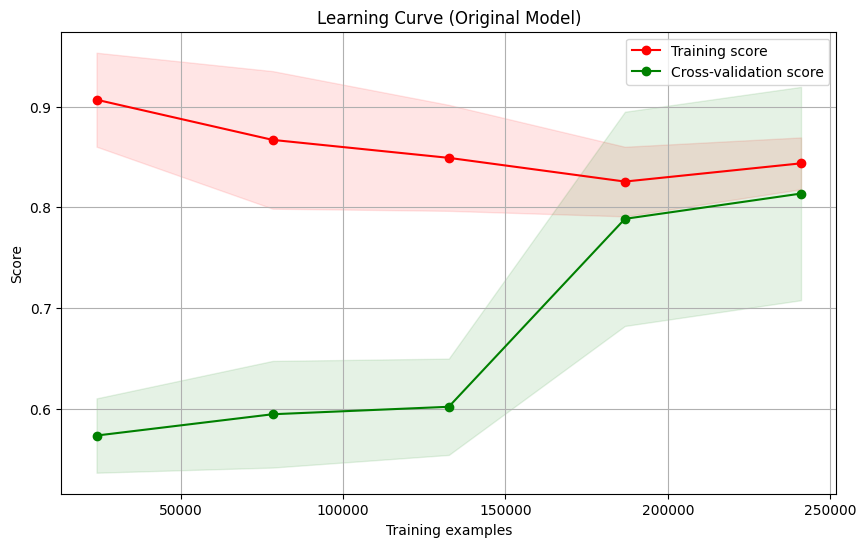

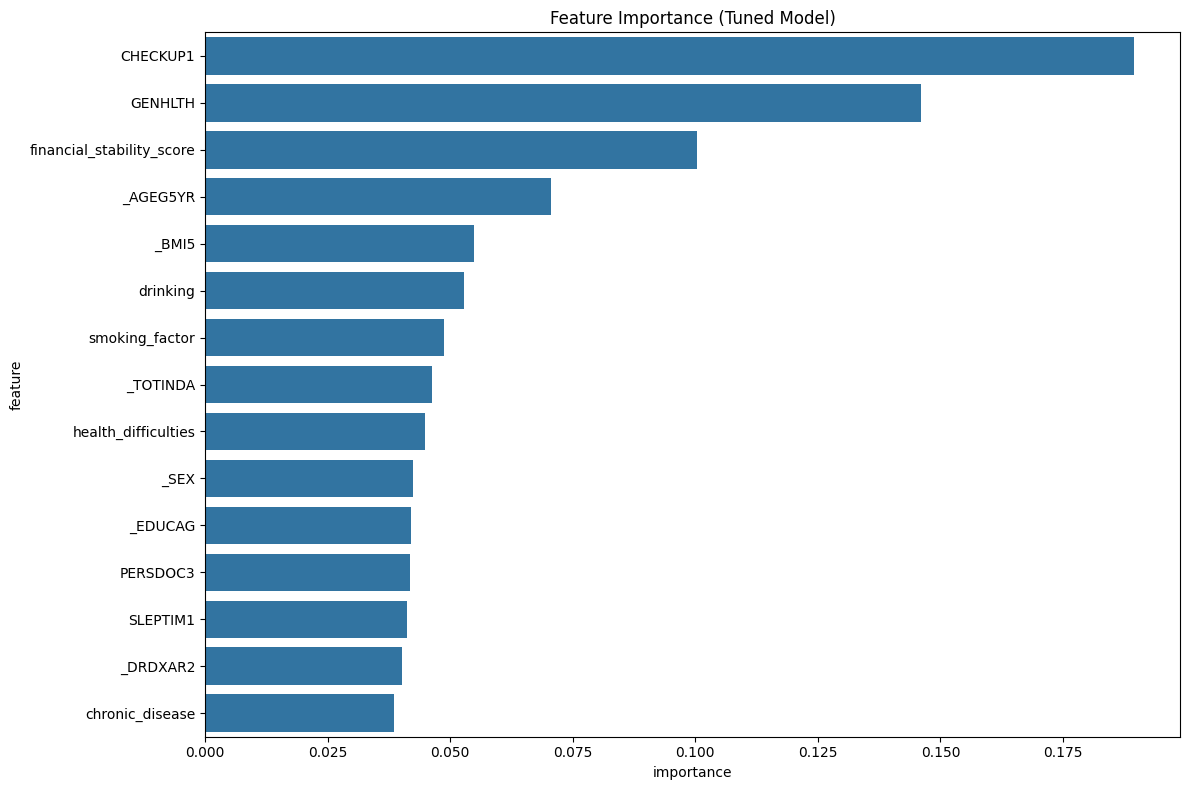

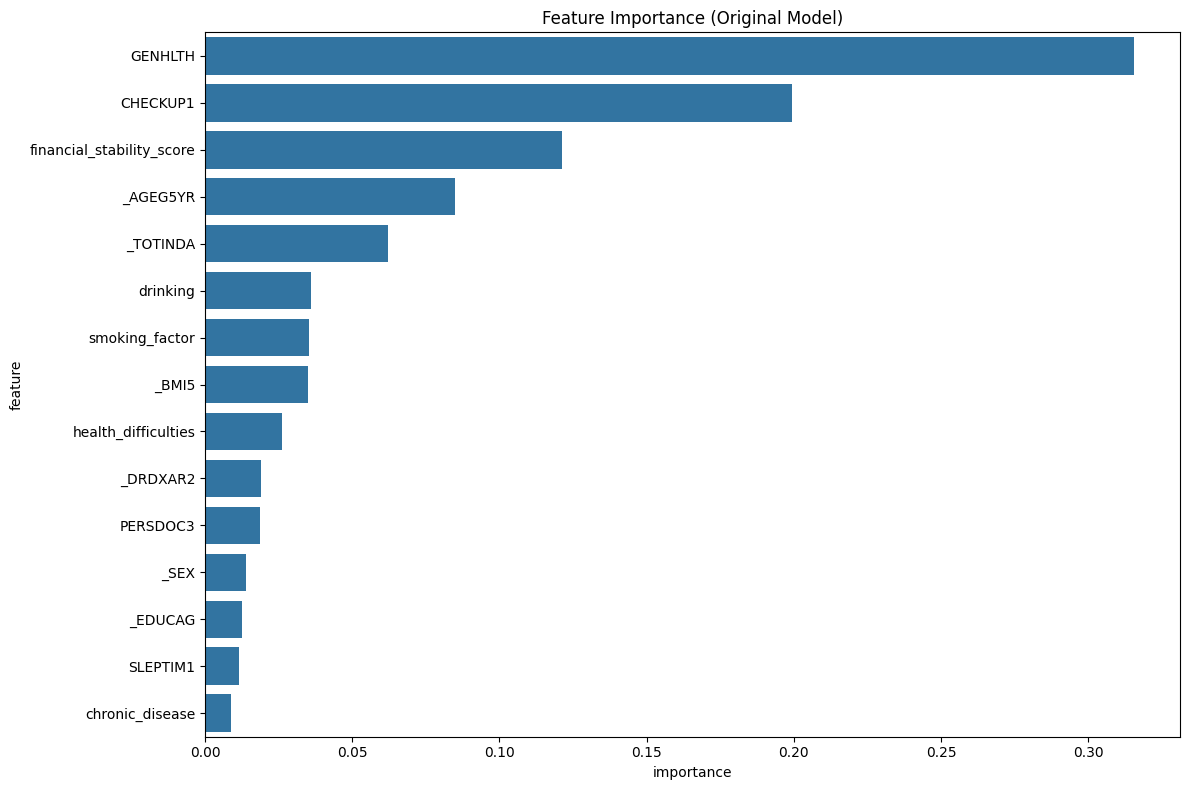

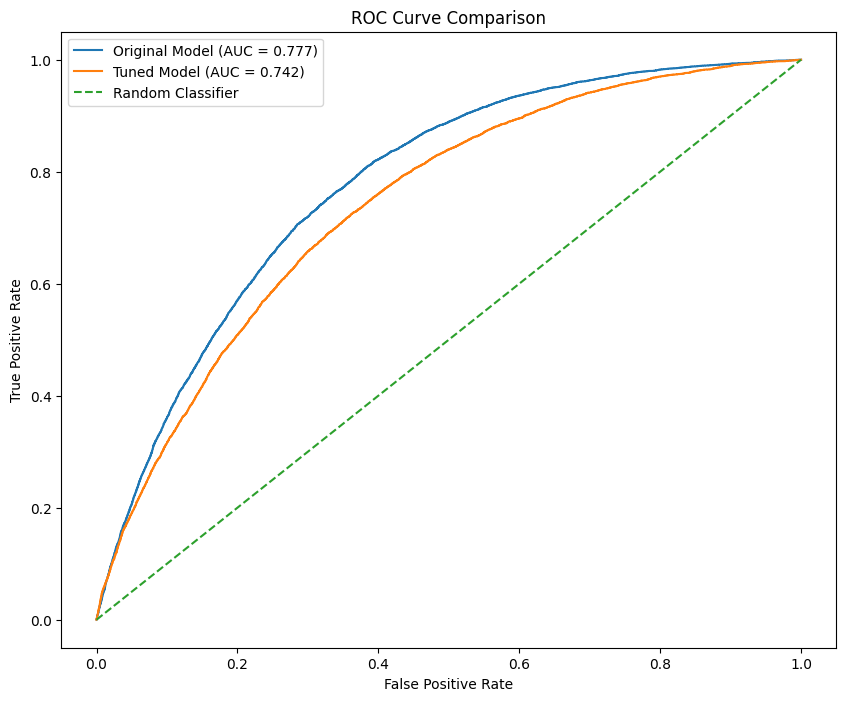

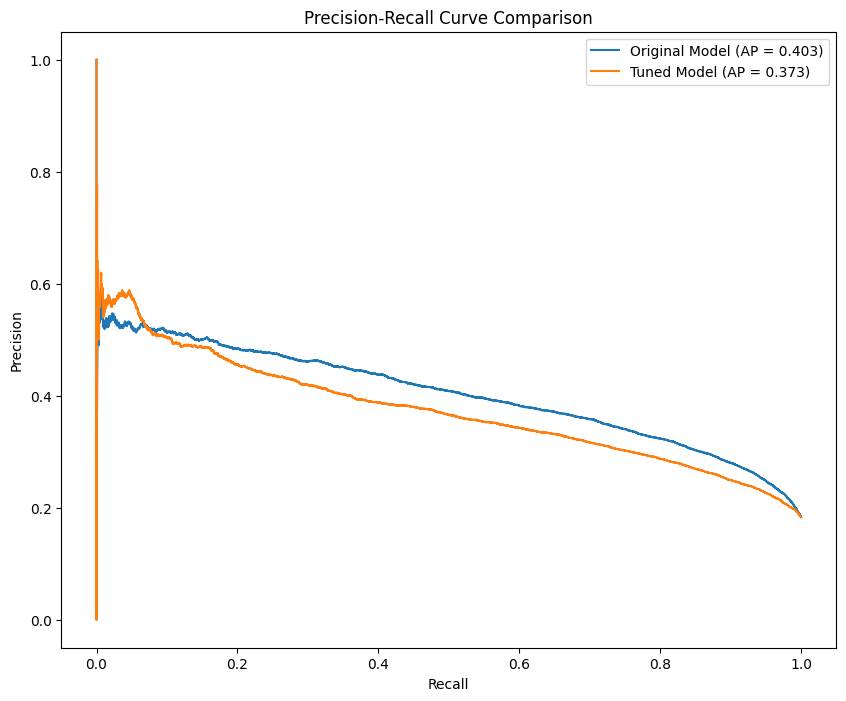

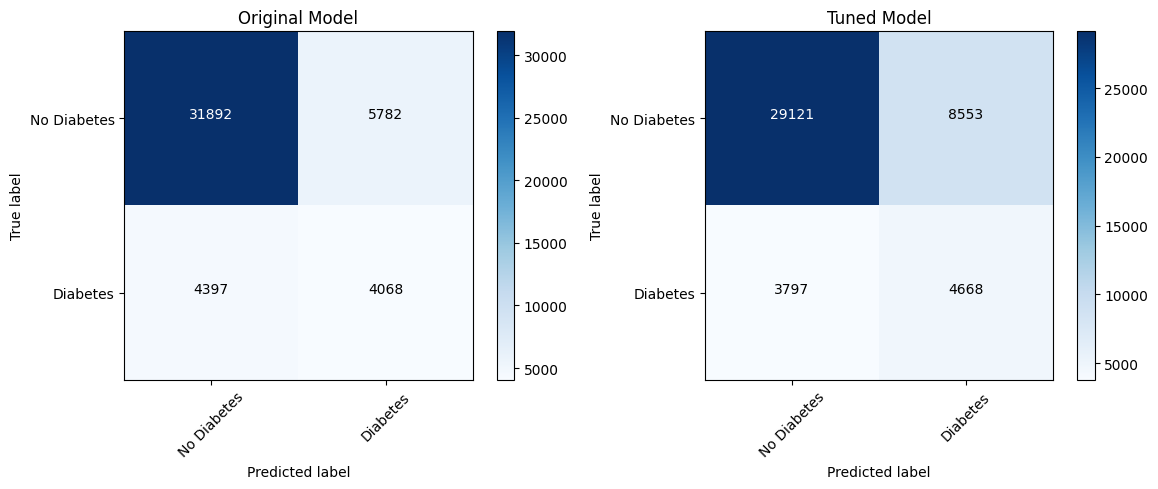

Original Model - ROC AUC: 0.7775, F1 Score: 0.4442
Tuned Model - ROC AUC: 0.7416, F1 Score: 0.4305


In [13]:

# 1. Hyperparameter Importance
def plot_param_importances(random_search):
    importances = pd.DataFrame.from_dict(random_search.cv_results_)
    importances = importances.filter(regex='^param_.*$|^mean_test_score$')
    #importances = importances.drop('param_random_state', axis=1)
    importances = pd.melt(importances, id_vars=['mean_test_score'], var_name='param')
    importances['param'] = importances['param'].str.replace('param_', '')
    importances = importances.groupby('param')['mean_test_score'].agg(['mean', 'std'])
    importances['coef_of_variation'] = importances['std'] / importances['mean']
    importances = importances.sort_values('coef_of_variation', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances.index, y='coef_of_variation', data=importances)
    plt.title('Hyperparameter Importance')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_param_importances(random_search)

# 2. Learning Curves
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(.1, 1.0, 5))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

plot_learning_curve(best_model, X_train, y_train, "Learning Curve (Tuned Model)")
plot_learning_curve(original_xgb, X_train, y_train, "Learning Curve (Original Model)")

# 3. Feature Importance Comparison
def plot_feature_importance(model, X, title):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_feature_importance(best_model, X, "Feature Importance (Tuned Model)")
plot_feature_importance(original_xgb, X, "Feature Importance (Original Model)")

# 4. ROC Curve Comparison
def plot_roc_curve(y_true, y_pred_proba, label):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.3f})')

plt.figure(figsize=(10, 8))
plot_roc_curve(y_test_full, original_y_pred_proba, 'Original Model')
plot_roc_curve(y_test_full, y_pred_proba, 'Tuned Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

# 5. Precision-Recall Curve Comparison
def plot_pr_curve(y_true, y_pred_proba, label):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    avg_precision = average_precision_score(y_true, y_pred_proba)
    plt.plot(recall, precision, label=f'{label} (AP = {avg_precision:.3f})')

plt.figure(figsize=(10, 8))
plot_pr_curve(y_test_full, original_y_pred_proba, 'Original Model')
plot_pr_curve(y_test_full, y_pred_proba, 'Tuned Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.show()

# 6. Confusion Matrix Comparison
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_confusion_matrix(confusion_matrix(y_test_full, original_y_pred), classes=['No Diabetes', 'Diabetes'], title='Original Model')
plt.subplot(122)
plot_confusion_matrix(confusion_matrix(y_test_full, y_pred), classes=['No Diabetes', 'Diabetes'], title='Tuned Model')
plt.show()

# Print final comparison
print("Original Model - ROC AUC: {:.4f}, F1 Score: {:.4f}".format(
    roc_auc_score(y_test_full, original_y_pred_proba), f1_score(y_test_full, original_y_pred)))
print("Tuned Model - ROC AUC: {:.4f}, F1 Score: {:.4f}".format(
    roc_auc_score(y_test_full, y_pred_proba), f1_score(y_test_full, y_pred)))

# Summary of overfitting

- The tuned model slightly underperformed compared to the original model:
    - Original Model: ROC AUC: 0.7775, F1 Score: 0.4442
    - Tuned Model: ROC AUC: 0.7416, F1 Score: 0.4305

- The tuned model showed improved recall for the positive class (diabetes) but at the cost of precision:
    - Original model: precision 0.41, recall 0.48 for the positive class
    - Tuned model: precision 0.35, recall 0.55 for the positive class


The learning curves suggest that both models might benefit from more data, as the validation score is still increasing with the maximum number of training examples.

# Feature engineering

Given that XGBoost performs well with interactions, I had not engineered this feature away. I will do so now to try to improve model performance

In [14]:
new_df = fdf.copy()
new_df.columns

Index(['GENHLTH', '_BMI5', '_AGEG5YR', 'financial_stability_score', '_DRDXAR2',
       'CHECKUP1', 'chronic_disease', 'drinking', 'SLEPTIM1', '_TOTINDA',
       '_SEX', 'PERSDOC3', '_EDUCAG', 'health_difficulties', 'smoking_factor',
       'diabetes'],
      dtype='object')

# Recursive Feature Elimination

We'll attempt recursive feature elimination to try to improve the model

In [15]:
# Split features and target
X = new_df.drop('diabetes', axis=1)
y = new_df['diabetes']

# train test split
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.2, random_state=random_state)

smote = SMOTE(random_state=random_state)
X_train, y_train = smote.fit_resample(X_train_full, y_train_full)

print(f"Training set shape after SMOTE: {X_train.shape}")
print(f"Class distribution after SMOTE: {pd.Series(y_train).value_counts(normalize=True)}")

Training set shape after SMOTE: (301282, 15)
Class distribution after SMOTE: diabetes
True     0.5
False    0.5
Name: proportion, dtype: float64


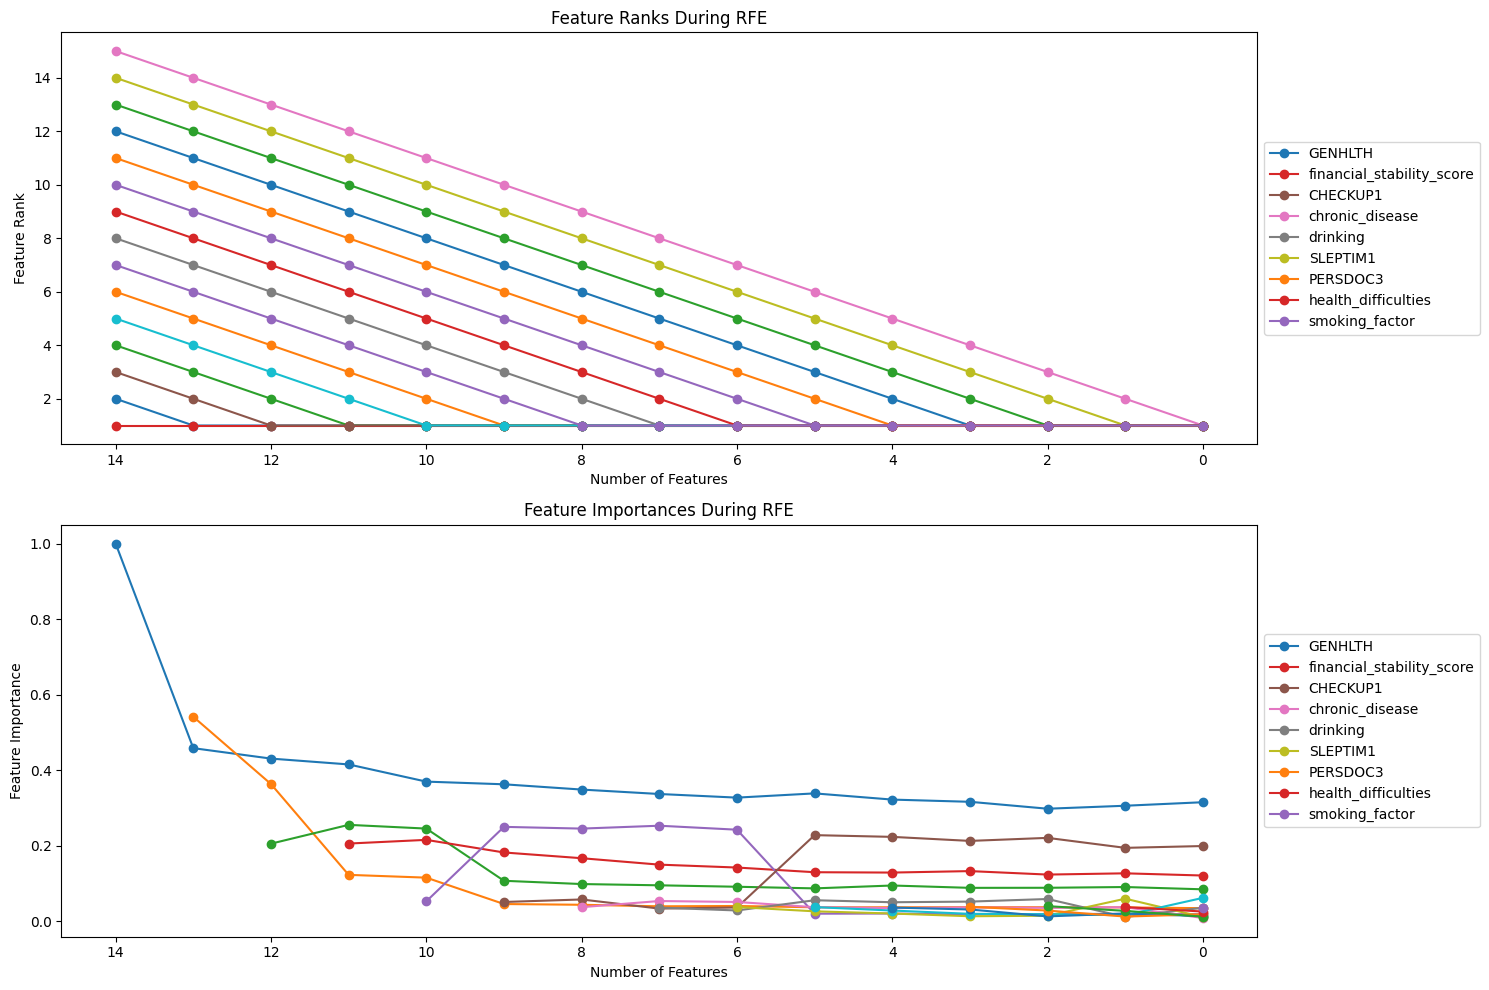

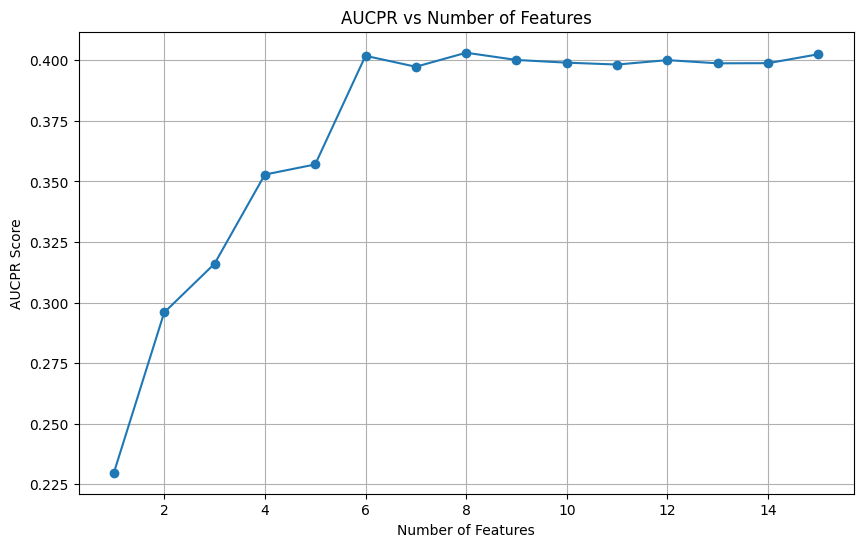

Optimal number of features: 8
Top 8 features: ['financial_stability_score', 'GENHLTH', 'CHECKUP1', '_AGEG5YR', '_TOTINDA', '_BMI5', 'smoking_factor', 'drinking']


In [16]:
# Create feature names
feature_names = X_train.columns

# Initialize the XGBoost classifier
clf = XGBClassifier(
    eval_metric='aucpr',
    random_state=random_state
)

# Initialize variables to store results
n_features_to_select = 1
n_features = X_train.shape[1]
feature_ranks = []
feature_importances = []
aucpr_scores = []

# Perform RFE
for i in range(n_features, n_features_to_select - 1, -1):
    rfe = RFE(estimator=clf, n_features_to_select=i, step=1)
    rfe.fit(X_train, y_train)
    
    # Get feature ranks and importances
    feature_ranks.append(rfe.ranking_)
    feature_importances.append(rfe.estimator_.feature_importances_)
    
    # Make predictions and calculate AUCPR
    y_pred_proba = rfe.predict_proba(X_test_full)[:, 1]
    aucpr_scores.append(average_precision_score(y_test_full, y_pred_proba))

# Convert results to DataFrames
ranks_df = pd.DataFrame(feature_ranks, columns=feature_names)
importances_df = pd.DataFrame(feature_importances, columns=feature_names)

# Plot the results
plt.figure(figsize=(15, 10))

# Plot feature ranks
plt.subplot(2, 1, 1)
ranks_df.plot(ax=plt.gca(), marker='o')
plt.title('Feature Ranks During RFE')
plt.xlabel('Number of Features')
plt.ylabel('Feature Rank')
plt.gca().invert_xaxis()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot feature importances
plt.subplot(2, 1, 2)
importances_df.plot(ax=plt.gca(), marker='o')
plt.title('Feature Importances During RFE')
plt.xlabel('Number of Features')
plt.ylabel('Feature Importance')
plt.gca().invert_xaxis()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Plot AUCPR vs number of features
plt.figure(figsize=(10, 6))
plt.plot(range(n_features, n_features_to_select - 1, -1), aucpr_scores, marker='o')
plt.title('AUCPR vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('AUCPR Score')
plt.grid(True)
plt.show()

# Print the optimal number of features
optimal_n_features = n_features - np.argmax(aucpr_scores)
print(f"Optimal number of features: {optimal_n_features}")

# Print the top features
top_features = ranks_df.iloc[-1].sort_values().index[:optimal_n_features].tolist()
print(f"Top {optimal_n_features} features: {top_features}")

# Summary

Our initial 15 features seem to be the best features to choose, and we know from the EDA that the remaining features we discarded would not improve things, so we seem to have the ideal set of features. Let's try engineering some additional features to see if we can improve their performance

# Feature engineering

In [17]:
new_df = fdf.copy()
new_df['AGE_BMI_Interation'] = new_df['_AGEG5YR'] * new_df['_BMI5']

In [18]:
X = new_df.drop('diabetes', axis=1)
y = new_df['diabetes']

# train test split
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.2, random_state=random_state)

smote = SMOTE(random_state=random_state)
X_train, y_train = smote.fit_resample(X_train_full, y_train_full)

print(f"Training set shape after SMOTE: {X_train.shape}")
print(f"Class distribution after SMOTE: {pd.Series(y_train).value_counts(normalize=True)}")

Training set shape after SMOTE: (301282, 16)
Class distribution after SMOTE: diabetes
True     0.5
False    0.5
Name: proportion, dtype: float64


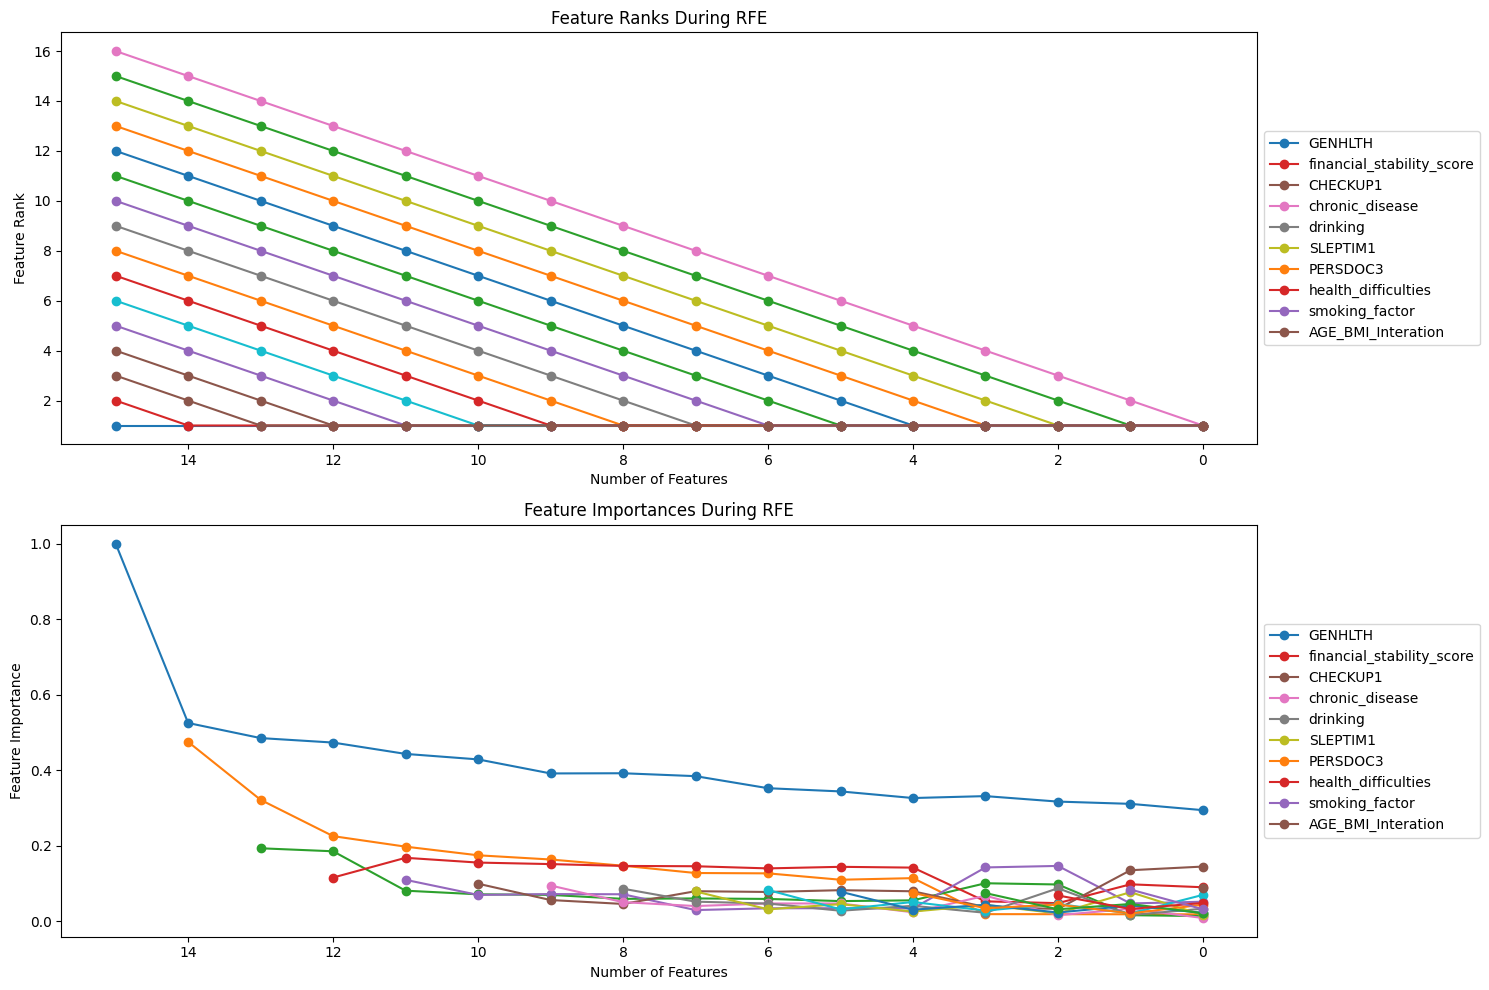

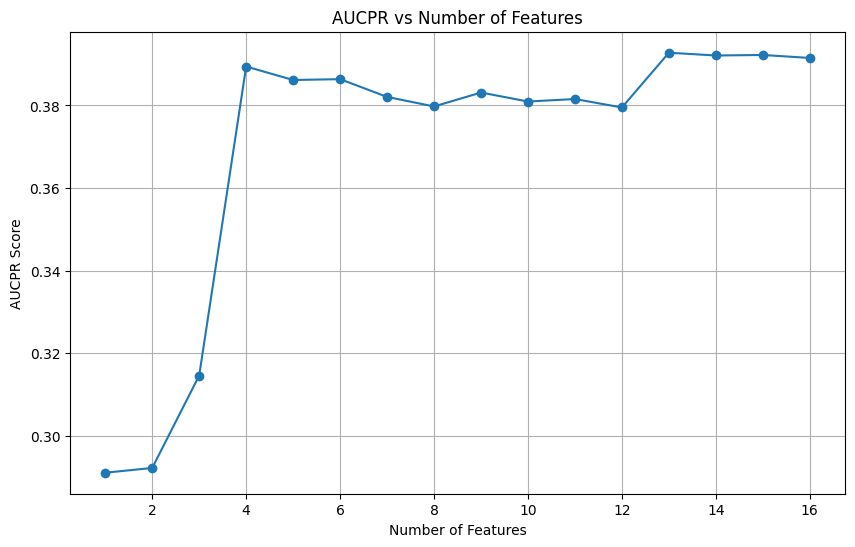

Optimal number of features: 13
Top 13 features: ['GENHLTH', 'financial_stability_score', 'CHECKUP1', 'AGE_BMI_Interation', '_DRDXAR2', '_TOTINDA', 'health_difficulties', 'PERSDOC3', 'drinking', 'smoking_factor', '_EDUCAG', '_SEX', '_BMI5']


In [19]:
# Create feature names
feature_names = X_train.columns

# Initialize the XGBoost classifier
clf = XGBClassifier(
    eval_metric='aucpr',
    random_state=random_state
)

# Initialize variables to store results
n_features_to_select = 1
n_features = X_train.shape[1]
feature_ranks = []
feature_importances = []
aucpr_scores = []

# Perform RFE
for i in range(n_features, n_features_to_select - 1, -1):
    rfe = RFE(estimator=clf, n_features_to_select=i, step=1)
    rfe.fit(X_train, y_train)
    
    # Get feature ranks and importances
    feature_ranks.append(rfe.ranking_)
    feature_importances.append(rfe.estimator_.feature_importances_)
    
    # Make predictions and calculate AUCPR
    y_pred_proba = rfe.predict_proba(X_test_full)[:, 1]
    aucpr_scores.append(average_precision_score(y_test_full, y_pred_proba))

# Convert results to DataFrames
ranks_df = pd.DataFrame(feature_ranks, columns=feature_names)
importances_df = pd.DataFrame(feature_importances, columns=feature_names)

# Plot the results
plt.figure(figsize=(15, 10))

# Plot feature ranks
plt.subplot(2, 1, 1)
ranks_df.plot(ax=plt.gca(), marker='o')
plt.title('Feature Ranks During RFE')
plt.xlabel('Number of Features')
plt.ylabel('Feature Rank')
plt.gca().invert_xaxis()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot feature importances
plt.subplot(2, 1, 2)
importances_df.plot(ax=plt.gca(), marker='o')
plt.title('Feature Importances During RFE')
plt.xlabel('Number of Features')
plt.ylabel('Feature Importance')
plt.gca().invert_xaxis()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Plot AUCPR vs number of features
plt.figure(figsize=(10, 6))
plt.plot(range(n_features, n_features_to_select - 1, -1), aucpr_scores, marker='o')
plt.title('AUCPR vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('AUCPR Score')
plt.grid(True)
plt.show()

# Print the optimal number of features
optimal_n_features = n_features - np.argmax(aucpr_scores)
print(f"Optimal number of features: {optimal_n_features}")

# Print the top features
top_features = ranks_df.iloc[-1].sort_values().index[:optimal_n_features].tolist()
print(f"Top {optimal_n_features} features: {top_features}")

# Expanded Analysis, Results Summary, and Conclusion

## Data Cleaning and Preparation

### Initial Data Overview
- Data Source: 2022 Behavioral Risk Factor Surveillance System (BRFSS) Survey Data from CDC
- Original dataset: 445,132 respondents with 328 variables
- Variables covered health behaviors, chronic conditions, and demographic information

### Data Cleaning Process
1. Handled missing and unknown values:
   - Removed rows with "don't know" or "refused" responses for most variables
   - Imputed missing values for some variables based on survey structure or using mode imputation
2. Recoded categorical variables:
   - Converted binary variables from 1/2 to 1/0 coding
   - Reordered ordinal variables to ensure logical progression
3. Created target variable:
   - Combined diabetes and pre-diabetes into a single binary target
4. Engineered new features:
   - Created a composite 'smoking_factor' from multiple smoking-related variables
   - Developed a 'financial_stability_score' from socioeconomic indicators
   - Combined disability indicators into a 'health_difficulties' feature
   - Created a 'chronic_disease' feature from various disease indicators
5. Dropped unusable or redundant columns
6. Handled remaining missing values by dropping rows

### Data Retention
- Final cleaned dataset: 230,693 respondents (51.83% of original data)
- 60 variables retained after cleaning and feature engineering

## Exploratory Data Analysis (EDA)

### Target Variable Distribution
- Significant class imbalance: approximately 80% non-diabetic vs. 20% diabetic
- This imbalance necessitated careful consideration in modeling approaches

### Key Feature Distributions and Relationships
1. Demographic Features:
   - Age (_AGEG5YR): Positive correlation with diabetes risk
   - Gender (_SEX): Weak correlation, suggesting complex relationship
   - Race (_IMPRACE): Varied distribution, with "White" being the most prevalent category

2. Health Status Indicators:
   - General Health (GENHLTH): Strong negative correlation with diabetes
   - BMI (_BMI5): Strong positive correlation with diabetes
   - Chronic Disease: Strong positive correlation with diabetes

3. Lifestyle Factors:
   - Physical Activity (_TOTINDA): Negative correlation with diabetes
   - Smoking (smoking_factor): Weak positive correlation, suggesting non-linear relationship
   - Drinking: Weak positive correlation, also suggesting non-linear relationship
   - Sleep Time (SLEPTIM1): Weak correlation, but identified as an important feature

4. Socioeconomic Factors:
   - Financial Stability Score: Positive correlation with diabetes, possibly due to healthcare access
   - Education Level (_EDUCAG): Weak negative correlation with diabetes

5. Healthcare Access:
   - Having a Personal Doctor (PERSDOC3): Weak correlation but identified as important
   - Checkup Frequency (CHECKUP1): Moderate negative correlation with diabetes

### Feature Selection
Used Balanced Random Forest Classifier for initial feature selection, identifying 15 top features:
1. GENHLTH (General Health)
2. _BMI5 (Body Mass Index)
3. _AGEG5YR (Age Group)
4. financial_stability_score
5. _DRDXAR2 (Arthritis diagnosis)
6. CHECKUP1 (Frequency of check-ups)
7. chronic_disease
8. drinking
9. SLEPTIM1 (Sleep time)
10. _TOTINDA (Physical activity)
11. _SEX (Gender)
12. PERSDOC3 (Having a personal doctor)
13. _EDUCAG (Education level)
14. health_difficulties
15. smoking_factor

## Analysis

### Key Findings

1. Multifaceted Nature of Diabetes Risk:
   - Diabetes risk is influenced by a complex interplay of health, lifestyle, demographic, and socioeconomic factors.
   - This underscores the need for a holistic approach to diabetes prediction and prevention.

2. Importance of Health Status:
   - General health (GENHLTH) emerged as the most important predictor, showing a strong negative correlation with diabetes risk.
   - BMI (_BMI5) was the second most important feature, with a strong positive correlation to diabetes risk.
   - The presence of other chronic diseases, particularly arthritis (_DRDXAR2), showed strong associations with diabetes risk.

3. Lifestyle Factors:
   - Physical activity (_TOTINDA) showed a moderate negative correlation with diabetes risk, emphasizing the protective effect of exercise.
   - Smoking and drinking behaviors showed weak positive correlations but were identified as important features, suggesting non-linear relationships.
   - Sleep time (SLEPTIM1) was identified as an important feature despite weak linear correlation, indicating a complex relationship with diabetes risk.

4. Demographic Factors:
   - Age (_AGEG5YR) was the third most important feature, showing a strong positive correlation with diabetes risk.
   - Gender (_SEX) showed a weak correlation but was identified as moderately important, suggesting a complex relationship that may interact with other factors.

5. Socioeconomic Factors:
   - The engineered financial_stability_score showed a positive correlation with diabetes. This counterintuitive result might reflect better access to healthcare and diagnosis among more financially stable individuals.
   - Education level (_EDUCAG) showed a weak negative correlation with diabetes risk, suggesting a slight protective effect of higher education.

6. Healthcare Access and Utilization:
   - Frequency of check-ups (CHECKUP1) was an important feature, showing a moderate negative correlation with diabetes risk.
   - Having a personal doctor (PERSDOC3) was identified as important despite weak correlation, suggesting its role in diabetes management or early diagnosis.

7. Non-linear Relationships:
   - Several important predictors (e.g., smoking_factor, drinking, SLEPTIM1) showed weak linear correlations but high feature importance, indicating non-linear relationships with diabetes risk.

### Statistical Validation
- T-tests confirmed significant differences between diabetic and non-diabetic groups for continuous variables (e.g., BMI, age, general health).
- Chi-square tests showed significant associations between categorical variables (e.g., arthritis, physical activity) and diabetes status.
- Logistic regression coefficients provided insights into the direction and strength of relationships for seemingly non-linear features.

## Conclusions and Implications

1. Holistic Approach Required:
   - The diverse range of important features spanning health status, lifestyle, demographics, and socioeconomic factors emphasizes the need for a comprehensive approach to diabetes risk assessment and prevention.

2. Personalized Risk Assessment:
   - The complex interplay of factors suggests that personalized risk assessments, taking into account an individual's unique combination of risk factors, could be more effective than a one-size-fits-all approach.

3. Importance of Lifestyle Interventions:
   - The significance of modifiable risk factors like BMI, physical activity, smoking, and drinking underscores the potential impact of lifestyle interventions in diabetes prevention.

4. Healthcare Access and Utilization:
   - The importance of regular check-ups and having a personal doctor highlights the role of healthcare access and utilization in managing diabetes risk.

5. Socioeconomic Considerations:
   - The complex relationship between financial stability and diabetes risk suggests the need for tailored interventions that consider socioeconomic factors and healthcare access.

6. Non-linear Modeling Approaches:
   - The presence of non-linear relationships for several key predictors indicates that advanced modeling techniques capable of capturing these complex patterns may be beneficial for accurate risk prediction.

7. Addressing Class Imbalance:
   - The significant class imbalance in the target variable necessitates careful consideration in model development, including the use of appropriate sampling techniques and evaluation metrics.

## Recommendations for Future Steps

1. Modeling Approach:
   - Utilize algorithms capable of capturing non-linear relationships, such as Gradient Boosting Machines (e.g., XGBoost) and Balanced Random Forests.
   - Implement SMOTE (Synthetic Minority Over-sampling Technique) to address class imbalance.
   - Consider using scale_pos_weight in XGBoost to further adjust class weights.

2. Feature Engineering:
   - Explore additional interaction terms or non-linear transformations of key features to capture complex relationships.
   - Investigate the possibility of creating more nuanced composite scores for lifestyle factors.

3. Model Evaluation:
   - Use metrics suited for imbalanced datasets, such as Area Under the ROC Curve (AUC-ROC), F1-Score, Precision-Recall Curve, and Balanced Accuracy.
   - Implement robust cross-validation to ensure model generalizability.

4. Interpretability:
   - Utilize model-agnostic interpretation techniques (e.g., SHAP values) to provide insights into feature impacts across different subgroups.

5. Longitudinal Analysis:
   - If possible, incorporate longitudinal data to assess how changes in risk factors over time impact diabetes onset.

6. External Validation:
   - Validate the model on external datasets to ensure generalizability across different populations.

7. Practical Application:
   - Develop user-friendly tools or interfaces that can translate the model's predictions into actionable insights for healthcare providers and individuals.
